# Volatility Forecasting using LSTM (BTC & S&P500)

This notebook implements a **univariate LSTM** model to forecast financial volatility using the **20-day realized volatility (rv20)** as the prediction target.

We run the same pipeline on two assets:
- **BTC-USD**
- **S&P500 (^GSPC)**

**Target:** `rv20` (proxy for conditional volatility)  
**Horizon:** 1-step ahead  
**Evaluation metrics:** RMSE, MAE


## 1. Imports

We import libraries for:
- data handling (`pandas`, `numpy`)
- plotting (`matplotlib`)
- scaling & metrics (`scikit-learn`)
- LSTM modelling (`TensorFlow/Keras`)


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


## 2. Environment check (TensorFlow)

We verify that TensorFlow is installed and accessible from the current notebook kernel.


In [48]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


## 3. Helper functions

We define:
- a sliding-window function to create supervised sequences
- a function to build an LSTM model
- a full pipeline function to train, forecast, evaluate, and plot results for a given asset


In [49]:
def create_sequences(data, window=20):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def build_lstm(input_shape, units=50, lr=0.001):
    model = Sequential([
        LSTM(units, activation="tanh", input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

def run_lstm_pipeline(csv_path, asset_name, lookback=20, train_ratio=0.8, epochs=30, batch_size=32):
    # ---- Load data
    df = pd.read_csv(csv_path)
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    df = df[["rv20"]].dropna()

    # ---- Plot rv20
    plt.figure(figsize=(10,4))
    plt.plot(df["rv20"])
    plt.title(f"Realized volatility (rv20) - {asset_name}")
    plt.show()

    # ---- Split
    train_size = int(len(df) * train_ratio)
    train = df.iloc[:train_size]
    test  = df.iloc[train_size:]

    # ---- Scale (fit on train only)
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled  = scaler.transform(test)

    # ---- Sequences
    X_train, y_train = create_sequences(train_scaled, lookback)
    X_test,  y_test  = create_sequences(test_scaled,  lookback)

    # ---- Build + Train
    model = build_lstm((X_train.shape[1], 1), units=50, lr=0.001)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )

    # ---- Loss plot
    plt.figure(figsize=(10,4))
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title(f"Training vs Validation Loss - {asset_name}")
    plt.legend()
    plt.show()

    # ---- Predict
    y_pred = model.predict(X_test)

    # invert scaling
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)

    # ---- Metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae  = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"===== {asset_name} Results =====")
    print("RMSE:", rmse)
    print("MAE :", mae)

    # ---- Forecast plot
    plt.figure(figsize=(10,4))
    plt.plot(y_test_inv, label="Realized Vol (rv20)")
    plt.plot(y_pred_inv, label="LSTM Forecast")
    plt.title(f"Volatility Forecasting with LSTM - {asset_name}")
    plt.legend()
    plt.show()

    return {"asset": asset_name, "rmse": rmse, "mae": mae}


## 4. Run the LSTM pipeline on BTC and S&P500

We run the exact same modelling steps on both assets for a fair comparison.


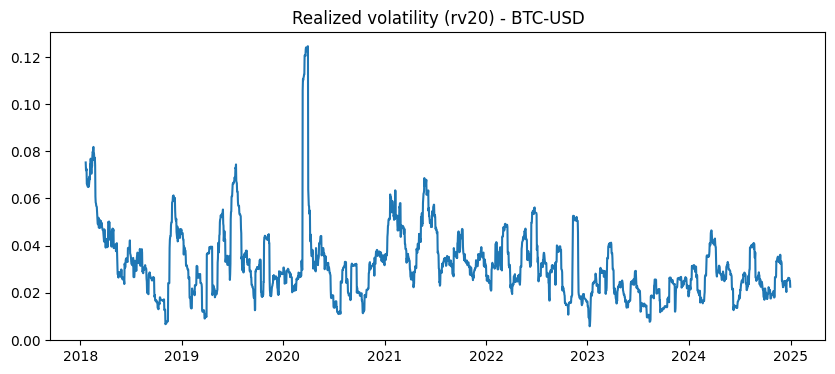

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0092 - val_loss: 0.0017
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 8.8878e-04
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 8.4720e-04
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 7.3777e-04
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 6.7444e-04
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 8.6242e-04
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 5.8634e-04
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 4.7929e-04
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 5.5614e-04
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - 

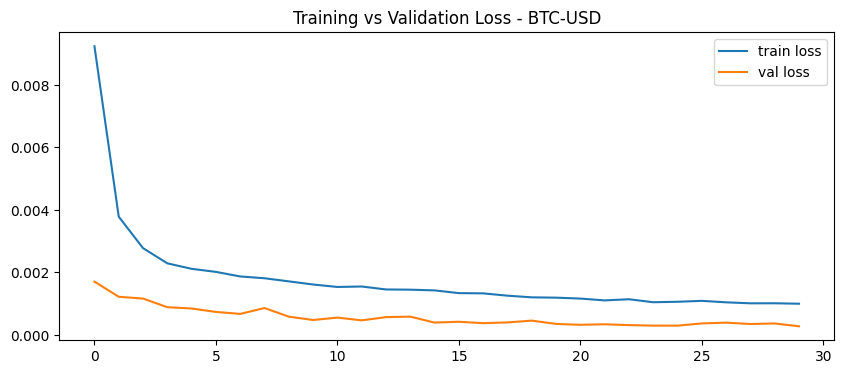

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
===== BTC-USD Results =====
RMSE: 0.0019272885175449627
MAE : 0.0011343539695087405


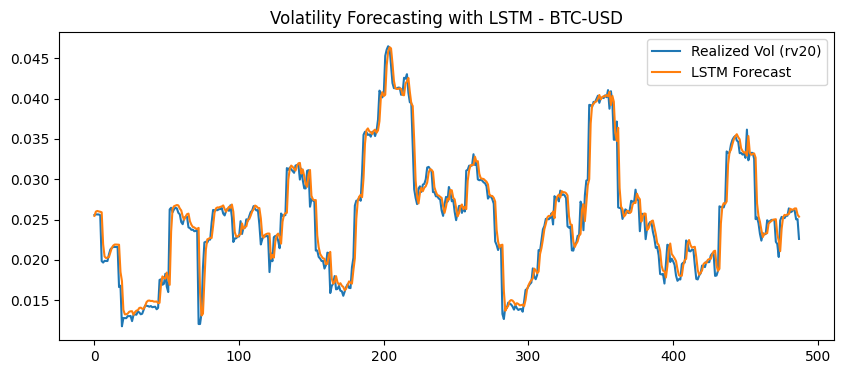

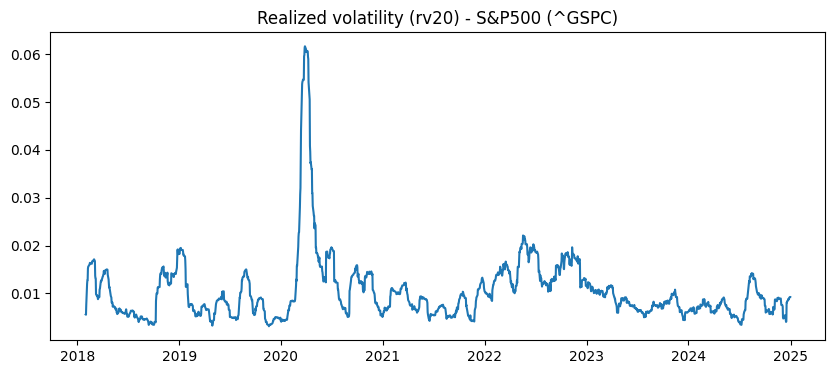

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0071 - val_loss: 0.0011
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 1.6079e-04
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 1.5399e-04
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 1.3583e-04
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7217e-04 - val_loss: 1.1757e-04
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0150e-04 - val_loss: 1.2498e-04
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3609e-04 - val_loss: 1.1715e-04
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6468e-04 - val_loss: 1.2420e-04
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2980e-04 - val_loss: 1.0111e-04
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8103e-04 - val_loss: 8.9392e-05
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3002e-04 - val_loss: 1.0402e-04
Epoch 12/30
39/3

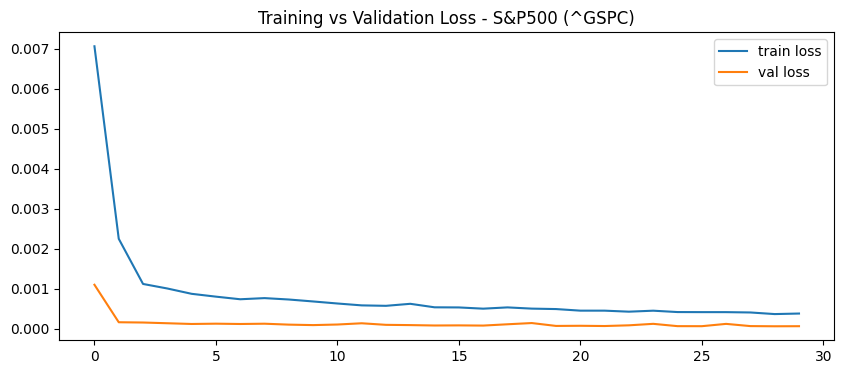

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
===== S&P500 (^GSPC) Results =====
RMSE: 0.0006015109304110661
MAE : 0.0004294802304220515


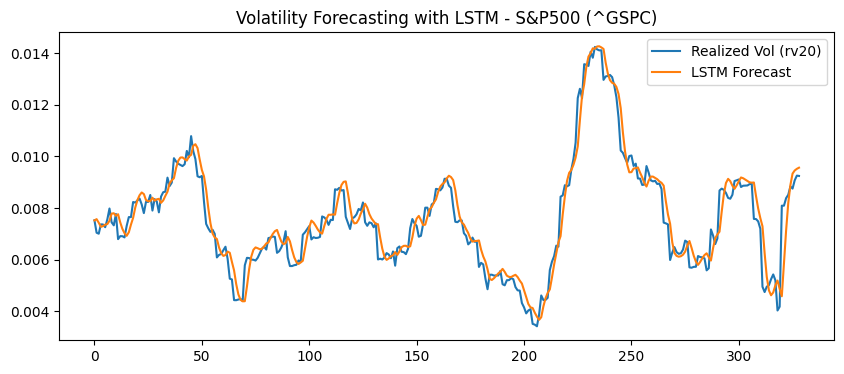

[{'asset': 'BTC-USD',
  'rmse': np.float64(0.0019272885175449627),
  'mae': 0.0011343539695087405},
 {'asset': 'S&P500 (^GSPC)',
  'rmse': np.float64(0.0006015109304110661),
  'mae': 0.0004294802304220515}]

In [50]:
results = []

results.append(
    run_lstm_pipeline("../data/sample/BTC-USD_sample.csv", "BTC-USD", lookback=20)
)

results.append(
    run_lstm_pipeline("../data/sample/GSPC_sample.csv", "S&P500 (^GSPC)", lookback=20)
)

results


## 5. Results summary

We summarize RMSE and MAE for both assets in a single table.


In [51]:
results_df = pd.DataFrame(results)
results_df


,asset,rmse,mae
0,BTC-USD,0.001927,0.001134
1,S&P500 (^GSPC),0.000602,0.000429


## 6. Conclusion

- We trained a univariate LSTM to predict **rv20** (realized volatility) using a sliding window.
- The pipeline was applied to **BTC-USD** and **S&P500** using the same settings.
- Next step: compare these results to GARCH-type volatility forecasts using the same metrics and (optionally) Diebold–Mariano test.
